## Import Library

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.applications import EfficientNetV2S
from keras.layers import Dense, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Activation
from keras.models import Sequential, load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
import tqdm
import imgaug.augmenters as iaa
import joblib
warnings.filterwarnings('ignore')

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
df_path=pd.read_csv('E:/COLLEGE/SEMESTER 5/Deep Learning/Tubes/data/train_data.csv')

images_path='E:/COLLEGE/SEMESTER 5/Deep Learning/Tubes/data/Train/'

df_path.columns=['filepaths', 'labels' ]
df_path['filepaths']=df_path['filepaths'].apply(lambda x: os.path.join(images_path,x))
df_path.head()

,filepaths,labels
0,E:/COLLEGE/SEMESTER 5/Deep Learning/Tubes/data...,Salmonella
1,E:/COLLEGE/SEMESTER 5/Deep Learning/Tubes/data...,Coccidiosis
2,E:/COLLEGE/SEMESTER 5/Deep Learning/Tubes/data...,Coccidiosis
3,E:/COLLEGE/SEMESTER 5/Deep Learning/Tubes/data...,Salmonella
4,E:/COLLEGE/SEMESTER 5/Deep Learning/Tubes/data...,New Castle Disease


In [ ]:
random_img = df_path.sample(200)

images = []
labels = []

for idx, row in random_img.iterrows():
    image = cv2.imread(row['filepaths'])

    images.append(image)
    labels.append(row['labels'])

images = np.array(images)
labels = np.array(labels)

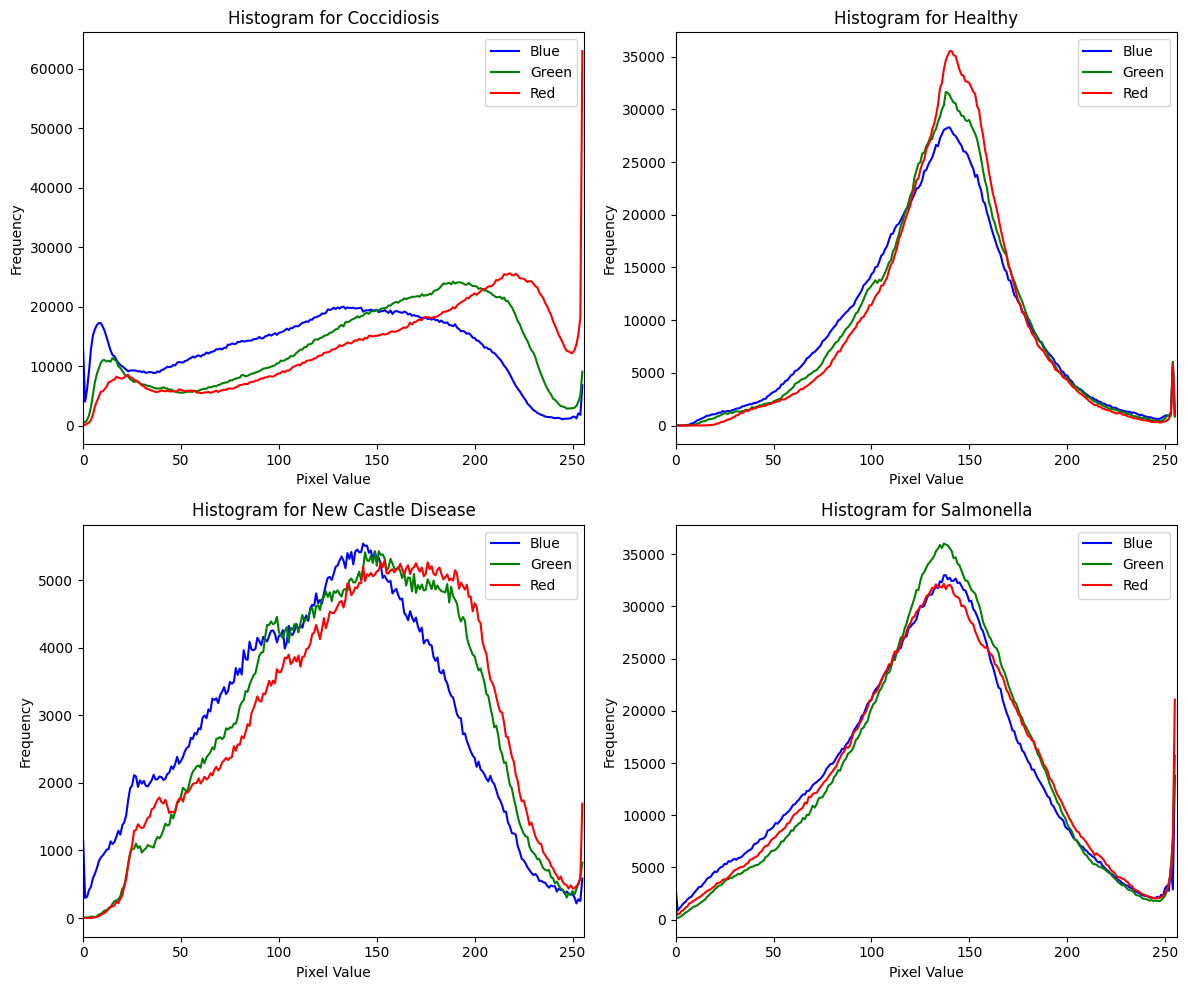

In [ ]:
# Melihat histogram berdasarkan labelnya
unique_labels = np.unique(labels)

# Membuat subplot dengan 2 baris dan 2 kolom
plt.figure(figsize=(12, 10))

# Plot histogram untuk setiap label
for i, label in enumerate(unique_labels[:4]):  # Maksimal 4 label untuk 2 baris dan 2 kolom
    plt.subplot(2, 2, i+1)

    label_indices = np.where(labels == label)[0]
    label_images = images[label_indices]

    # Inisialisasi array untuk menampung histogram perkanal
    channel_hist = np.zeros((3, 256))  # Ukuran (3, 256) untuk 3 kanal warna (BGR)

    # Menghitung histogram rata-rata untuk setiap kanal warna
    for j in range(3):  # Loop untuk setiap kanal warna (BGR)
        for image in label_images:
            hist = cv2.calcHist([image], [j], None, [256], [0, 256])
            channel_hist[j] += hist[:, 0]

    # Plot histogram pada subplot yang sesuai
    plt.title(f'Histogram for {label}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    colors = ('b', 'g', 'r')
    for j, color in enumerate(colors):
        plt.plot(channel_hist[j], color=color)
        plt.xlim([0, 256])
    plt.legend(['Blue', 'Green', 'Red'])

# Menampilkan plot
plt.tight_layout()
plt.show()


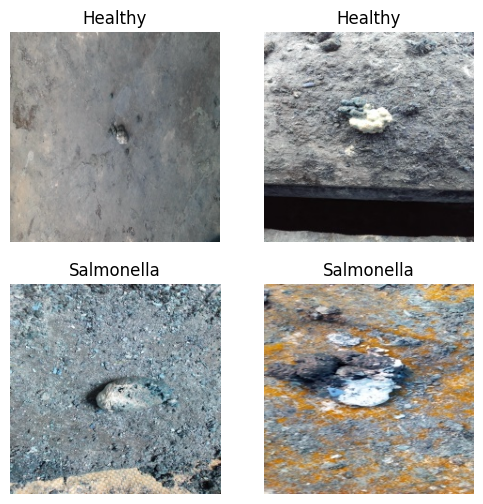

In [ ]:
# menampilkan data
plt.figure(figsize=(6,6))
x = 1
for i in np.random.randint(0,len(images),4):
    plt.subplot(2, 2, x)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
    x += 1

In [ ]:
# melihat shape data
print('Images Shape :',images.shape)
print('Labels Shape :',labels.shape)

Images Shape : (20, 224, 224, 3)
Labels Shape : (20,)


## Load, Color Conversion, Resize, Labelling

In [ ]:
Size = 180
images = []
labels = []

for idx, row in df_path.iterrows():
    image = cv2.imread(row['filepaths'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (Size, Size))

    images.append(image)
    labels.append(row['labels'])

images = np.array(images)
labels = np.array(labels)


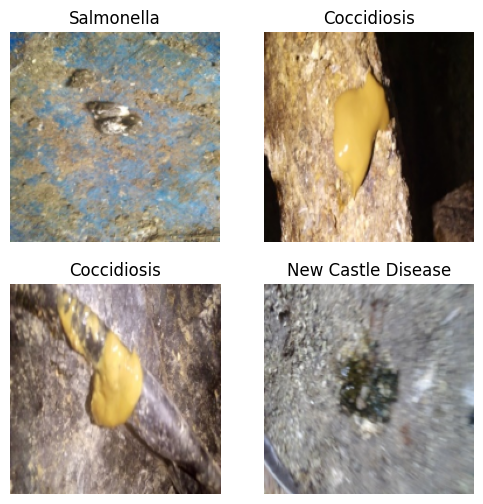

In [ ]:
# menampilkan data
plt.figure(figsize=(6,6))
x = 1
for i in np.random.randint(0,len(images),4):
    plt.subplot(2, 2, x)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
    x += 1

In [ ]:
# melihat shape data
print('Images Shape :',images.shape)
print('Labels Shape :',labels.shape)

Images Shape : (8067, 180, 180, 3)
Labels Shape : (8067,)


In [ ]:
lab = pd.DataFrame({'labels':labels})
lab.value_counts()

labels            
Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
dtype: int64

<Axes: title={'center': 'Jumlah Data Berdasarkan Kelas'}, ylabel='count'>

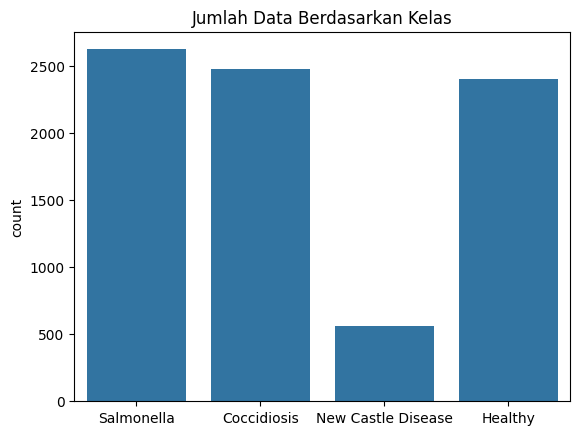

In [ ]:
plt.title('Jumlah Data Berdasarkan Kelas')
sns.countplot(x=labels)

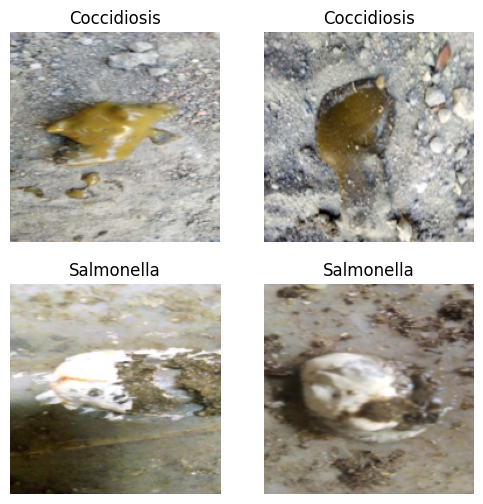

In [ ]:
# menampilkan data
plt.figure(figsize=(6,6))
x = 1
for i in np.random.randint(0,len(images),4):
    plt.subplot(2, 2, x)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
    x += 1

## Augmentasi Data

In [ ]:
# augmentasi data
aug = iaa.Sequential([
    iaa.Fliplr(),  # Flip
    iaa.Affine(rotate=(-30, 30)),  # Rotasi -30 - 30 degree
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Blur antara 0 - 1
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)), # Noise dengan prob. 50%
    iaa.Multiply((0.5, 1.5)) # mencerahkan * antara 0.5-1.5
])

# jumlah augmentasi
num_augmented_images = 4

augmented_images = []
augmented_labels = []

# label yang diaugmentasi
target_label = 'New Castle Disease'

for i in range(len(images)):
    current_image = images[i]
    current_label = labels[i]

    augmented_images.append(current_image)
    augmented_labels.append(current_label)

    if current_label == target_label:
        for _ in range(num_augmented_images):
            augmented = aug(images=[current_image])[0]
            augmented_images.append(augmented)
            augmented_labels.append(current_label)

images = np.array(augmented_images)
labels = np.array(augmented_labels)


In [ ]:
print('Images Shape :',images.shape)
print('Labels Shape :',labels.shape)

Images Shape : (10315, 180, 180, 3)
Labels Shape : (10315,)


In [ ]:
lab = pd.DataFrame({'labels':labels})
lab.value_counts()

labels            
New Castle Disease    2810
Salmonella            2625
Coccidiosis           2476
Healthy               2404
dtype: int64

<Axes: title={'center': 'Jumlah Data Berdasarkan Kelas'}, ylabel='count'>

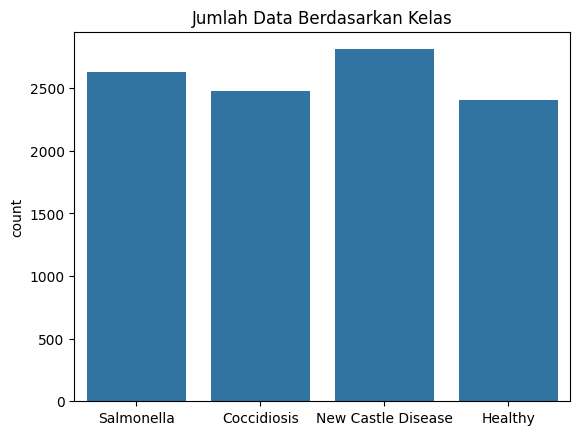

In [ ]:
plt.title('Jumlah Data Berdasarkan Kelas')
sns.countplot(x=labels)

## Hasil Augmentasi

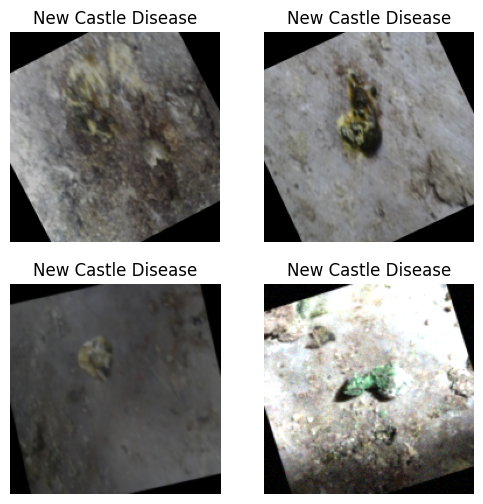

In [ ]:
# Melihat hasil augmentasi
target = [i for i in range(len(images)) if labels[i] == target_label]

plt.figure(figsize=(6, 6))
x = 1
selected_indices = np.random.choice(target, 4, replace=False)
for i in selected_indices:
    plt.subplot(2, 2, x)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
    x += 1

plt.show()


## Label Encoding

In [ ]:
# label encoding
le=LabelEncoder()
labels=le.fit_transform(labels)

joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

In [ ]:
# splitting data menjadi train, test, val
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1, shuffle=True, stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=1, shuffle =True, stratify=y_test)


# Modelling

In [ ]:
# model = Sequential()

# model.add(Conv2D(8, (3,3), 1, activation='relu', input_shape=(128,128,3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D())
# model.add(Dropout(0.3))

# model.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
# model.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
# model.add(MaxPooling2D())

# model.add(Conv2D(32, (3,3), 1, activation='relu', padding='same'))
# model.add(Conv2D(32, (3,3), 1, activation='relu', padding='same'))
# model.add(MaxPooling2D())

# model.add(Conv2D(64, (3,3), 1, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
# model.add(Conv2D(64, (3,3), 1, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
# model.add(MaxPooling2D())

# model.add(Conv2D(128, (3,3), 1, activation='relu', padding='same'))
# model.add(Conv2D(128, (3,3), 1, activation='relu', padding='same'))
# model.add(MaxPooling2D())

# model.add(Conv2D(256, (3,3), 1, activation='relu', padding='same'))
# model.add(Conv2D(256, (3,3), 1, activation='relu', padding='same'))
# model.add(MaxPooling2D())

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(4, activation='softmax'))

In [ ]:
# earlystop = EarlyStopping(patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0)
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics='accuracy')
# hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_val,y_val), callbacks=[checkpoint, earlystop], batch_size=512)

In [ ]:
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(180, 180, 3),
                              pooling='max')

for layer in base_model.layers:
    layer.trainable =  False

x = base_model.output
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)


predictions = Dense(4, activation='Softmax')(x)

model = Model(base_model.input, predictions)

In [ ]:
earlystop = EarlyStopping(patience=2,restore_best_weights=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), callbacks=[earlystop], batch_size=256)

Epoch 1/30
33/33 [==============================] - 38s 632ms/step - loss: 1.9742 - accuracy: 0.6335 - val_loss: 0.3578 - val_accuracy: 0.8710
Epoch 2/30
33/33 [==============================] - 17s 531ms/step - loss: 0.3202 - accuracy: 0.8867 - val_loss: 0.2906 - val_accuracy: 0.8991
Epoch 3/30
33/33 [==============================] - 17s 531ms/step - loss: 0.2383 - accuracy: 0.9159 - val_loss: 0.2856 - val_accuracy: 0.9020
Epoch 4/30
33/33 [==============================] - 17s 527ms/step - loss: 0.1994 - accuracy: 0.9294 - val_loss: 0.2191 - val_accuracy: 0.9321
Epoch 5/30
33/33 [==============================] - 17s 528ms/step - loss: 0.1838 - accuracy: 0.9338 - val_loss: 0.2050 - val_accuracy: 0.9273
Epoch 6/30
33/33 [==============================] - 17s 523ms/step - loss: 0.1620 - accuracy: 0.9435 - val_loss: 0.2067 - val_accuracy: 0.9302
Epoch 7/30
33/33 [==============================] - 17s 530ms/step - loss: 0.1570 - accuracy: 0.9460 - val_loss: 0.2126 - val_accuracy: 0.9176

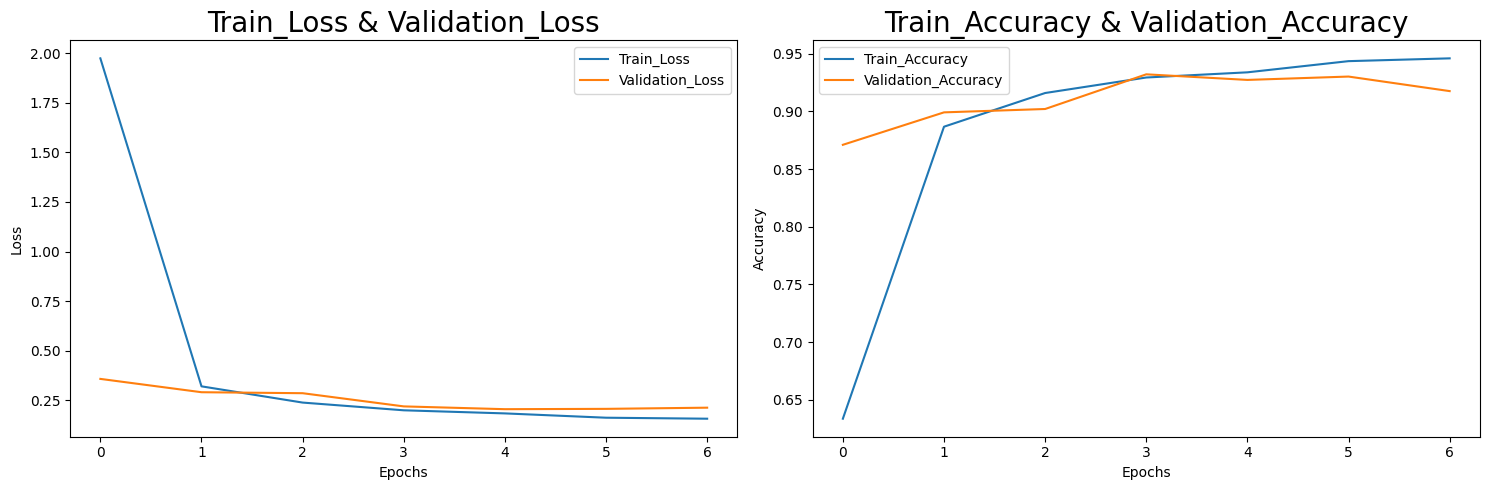

In [ ]:
hist_=pd.DataFrame(hist.history) # memasukkan history ke dataframe agar dapat di plotting
plt.figure(figsize=(15, 5))

# Subplot 1 - Loss
plt.subplot(1, 2, 1)
plt.plot(hist_['loss'], label='Train_Loss')
plt.plot(hist_['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot 2 - Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_['accuracy'], label='Train_Accuracy')
plt.plot(hist_['val_accuracy'], label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), callbacks=[earlystop,checkpoint], batch_size=512)


Epoch 1/30
17/17 [==============================] - 33s 1s/step - loss: 0.1580 - accuracy: 0.9460 - val_loss: 0.1900 - val_accuracy: 0.9370
Epoch 2/30
17/17 [==============================] - 19s 1s/step - loss: 0.1281 - accuracy: 0.9561 - val_loss: 0.1852 - val_accuracy: 0.9379
Epoch 3/30
17/17 [==============================] - 19s 1s/step - loss: 0.1203 - accuracy: 0.9569 - val_loss: 0.1731 - val_accuracy: 0.9447
Epoch 4/30
17/17 [==============================] - 19s 1s/step - loss: 0.1009 - accuracy: 0.9658 - val_loss: 0.1692 - val_accuracy: 0.9467
Epoch 5/30
17/17 [==============================] - 18s 1s/step - loss: 0.1026 - accuracy: 0.9647 - val_loss: 0.1809 - val_accuracy: 0.9437
Epoch 6/30
17/17 [==============================] - 19s 1s/step - loss: 0.0943 - accuracy: 0.9696 - val_loss: 0.1597 - val_accuracy: 0.9496
Epoch 7/30
17/17 [==============================] - 18s 1s/step - loss: 0.0870 - accuracy: 0.9706 - val_loss: 0.1629 - val_accuracy: 0.9515
Epoch 8/30
17/17 [==

## Plot Training

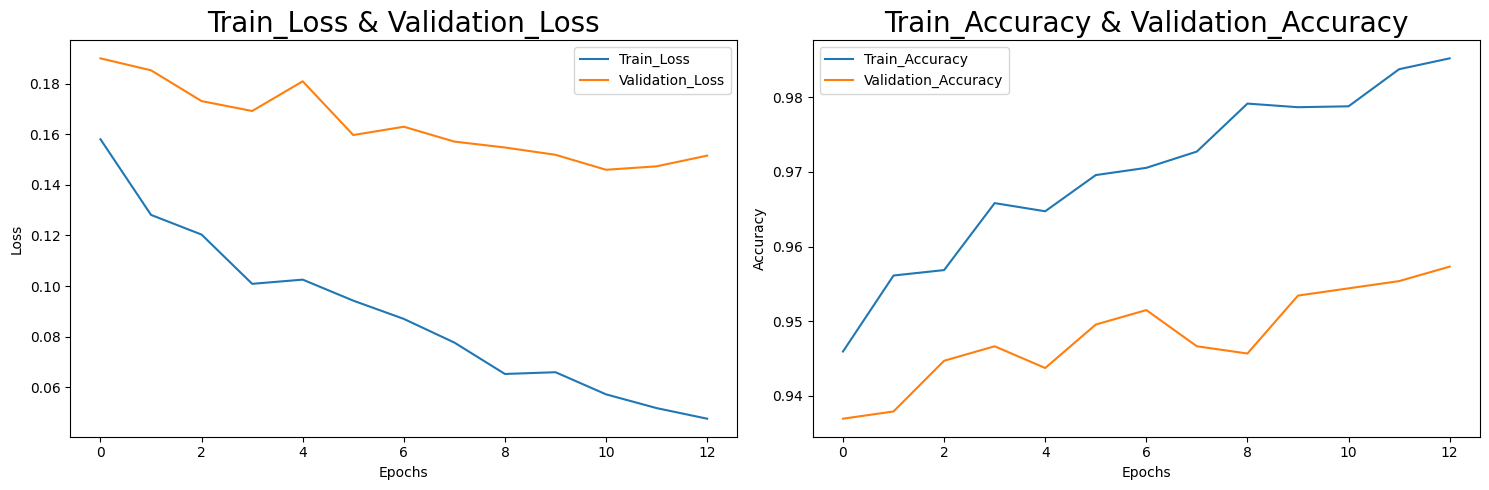

In [ ]:
hist_=pd.DataFrame(hist.history) # memasukkan history ke dataframe agar dapat di plotting
plt.figure(figsize=(15, 5))

# Subplot 1 - Loss
plt.subplot(1, 2, 1)
plt.plot(hist_['loss'], label='Train_Loss')
plt.plot(hist_['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot 2 - Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_['accuracy'], label='Train_Accuracy')
plt.plot(hist_['val_accuracy'], label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test Accuracy

In [ ]:
model = load_model('best_model.h5')

In [ ]:
score, acc = model.evaluate(x_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

33/33 [==============================] - 5s 51ms/step - loss: 0.1105 - accuracy: 0.9671
Test Loss = 0.11046081781387329
Test Accuracy = 0.9670542478561401


## Predict X test

In [ ]:
# memprediksi x_test dan memasukkannya ke dataframe
prediction = model.predict(x_test)
y_pred=np.argmax(prediction, axis=1)
df=pd.DataFrame()
df['Actual'],df['Prediction']=le.inverse_transform(y_test),le.inverse_transform(y_pred)
df

33/33 [==============================] - 4s 54ms/step


,Actual,Prediction
0,Healthy,Healthy
1,Salmonella,Salmonella
2,New Castle Disease,New Castle Disease
3,Coccidiosis,Coccidiosis
4,Coccidiosis,Coccidiosis
...,...,...
1027,Coccidiosis,Coccidiosis
1028,Coccidiosis,Coccidiosis
1029,Coccidiosis,Coccidiosis
1030,New Castle Disease,New Castle Disease


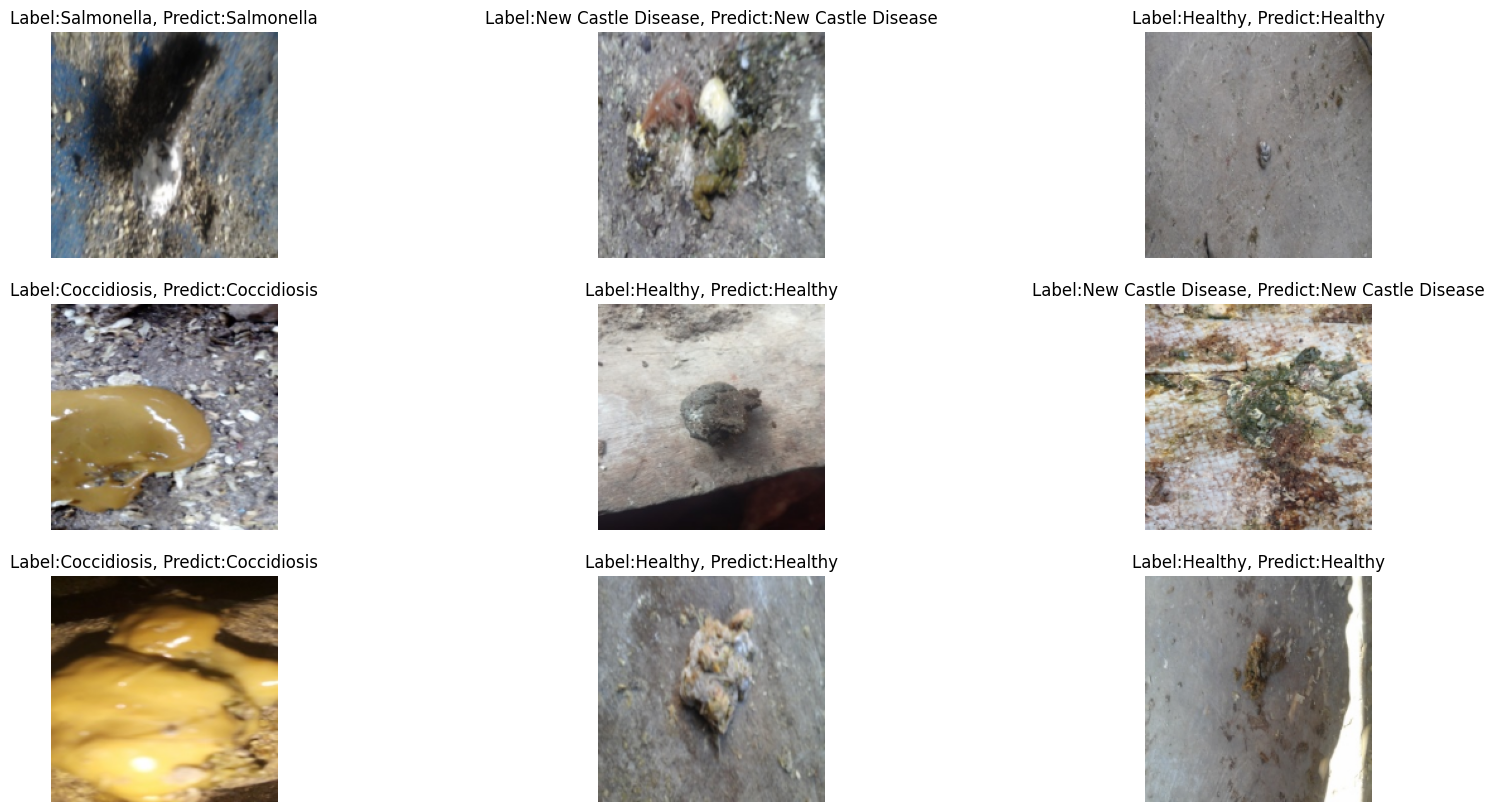

In [ ]:
# melihat hasil perbandingkan label dan prediksi
y_test2=le.inverse_transform(y_test)
y_pred2=le.inverse_transform(y_pred)
plt.figure(figsize=(20,10))
x = 1
for i in np.random.randint(0,len(x_test),9):
    plt.subplot(3, 3, x)
    plt.imshow(x_test[i])
    plt.title(f'Label:{y_test2[i]}, Predict:{y_pred2[i]}', fontsize=12)
    plt.axis('off')
    x += 1

## Confusion Matrix

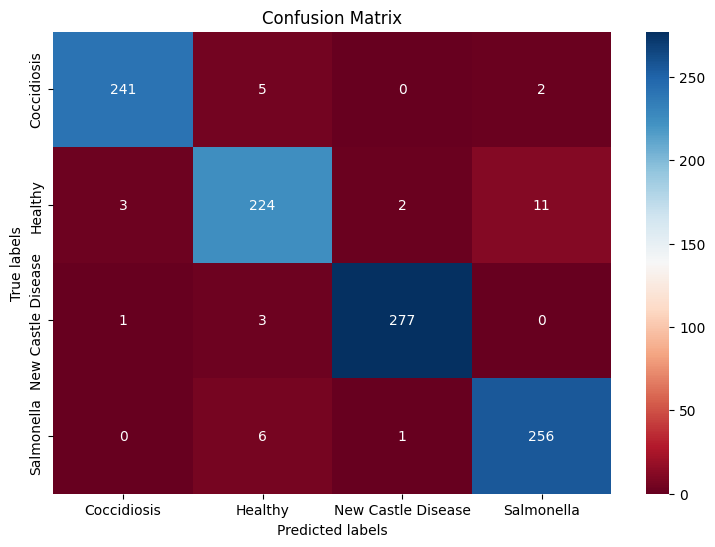

In [ ]:
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

CM = confusion_matrix(y_test_original, y_pred_original)

class_labels = le.classes_

plt.figure(figsize=(9, 6))
sns.heatmap(CM, annot=True, fmt='g', cmap='RdBu', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## Classification Report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       248
           1       0.94      0.93      0.94       240
           2       0.99      0.99      0.99       281
           3       0.95      0.97      0.96       263

    accuracy                           0.97      1032
   macro avg       0.97      0.97      0.97      1032
weighted avg       0.97      0.97      0.97      1032

